In [10]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from datetime import datetime, timedelta
import time

In [11]:
url_hub = 'https://www.dhhs.vic.gov.au/media-hub-coronavirus-disease-covid-19'
pull_hub = requests.get(url_hub).content
soup_hub = BeautifulSoup(pull_hub, 'html.parser')
link_list = []
for link in soup_hub.find_all('a'):
    if (type(link.get('href')) == str):
        if ('coronavirus-update-victoria' in link.get('href')):
            if link.get('href')[0] == "/":
                link_list.append("https://www.dhhs.vic.gov.au"+link.get('href'))
            else:
                link_list.append(link.get('href'))
                
link_list = link_list[:link_list.index('https://www.dhhs.vic.gov.au/coronavirus-update-victoria-07-may-2020')+1][::-1]

start_date = datetime(2020,5,7) #Starting from the 7th of May 2020, Victoria DHHS started using a table to report active and total coronavirus cases
end_date = datetime.today()
date_list = pd.date_range(start_date,end_date,freq='d')[:len(link_list)]

In [12]:
full_df = pd.DataFrame(columns = ["LGA","Total","Active","Date"])
for date, link in zip(date_list, link_list): #zip up the lists 
    
    try:
        pull = requests.get(link).content #grab the content for the link
        soup = BeautifulSoup(pull, 'html.parser') #parse the content using BeautifulSoup
#         table = soup.find_all('tbody')[0].findAll('tr') #find the table with all instances with of a table row
        print(f"{date}, update scraped")
    except IndexError:
        print(f"{date}, no update available") #if there is no table, continue
        continue
        
    df = pd.DataFrame(columns = ["LGA","Total","Active","Date"]) #create a DataFrame
    for row in soup.find_all('tbody')[0].findAll('tr'): #for each 'tr' or row stored in table
        row_data = row.findAll('td') #find all instances of 'td' or table data (cells)
        row_list = [x.text.replace("*","").replace(u'\xa0', u' ').lstrip().rstrip() for x in row_data] #remove the \n, \xa tags, and * 
        if len(row_list) == 0: #some anomalies where 'tr' tags have no data
            continue
        if len(row_list) == 1: #headers in the table that occupy 1 cell
            continue
        if len(row_list) == 2: #no active cases and a blank Active cell
            row_list.append('0')

        row_list = [0 if (x == '' or x == '-') else x for x in row_list] #replace blank strings or '-' with 0

        df = df.append({"LGA":row_list[0],
                   "Total":row_list[1],
                   "Active":row_list[2],
                    "Date":date},ignore_index=True) #append the data we've collected to DataFrame


    full_df = full_df.append(df) #append DataFrame to the full DataFrame
    time.sleep(0.1)

full_df.LGA = full_df.LGA.replace("WANGARRATTA","WANGARATTA")



2020-05-07 00:00:00, update scraped
2020-05-08 00:00:00, update scraped
2020-05-09 00:00:00, update scraped
2020-05-10 00:00:00, update scraped
2020-05-11 00:00:00, update scraped
2020-05-12 00:00:00, update scraped
2020-05-13 00:00:00, update scraped
2020-05-14 00:00:00, update scraped
2020-05-15 00:00:00, update scraped
2020-05-16 00:00:00, update scraped
2020-05-17 00:00:00, update scraped
2020-05-18 00:00:00, update scraped
2020-05-19 00:00:00, update scraped
2020-05-20 00:00:00, update scraped
2020-05-21 00:00:00, update scraped
2020-05-22 00:00:00, update scraped
2020-05-23 00:00:00, update scraped
2020-05-24 00:00:00, update scraped
2020-05-25 00:00:00, update scraped
2020-05-26 00:00:00, update scraped
2020-05-27 00:00:00, update scraped
2020-05-28 00:00:00, update scraped
2020-05-29 00:00:00, update scraped
2020-05-30 00:00:00, update scraped
2020-05-31 00:00:00, update scraped
2020-06-01 00:00:00, update scraped
2020-06-02 00:00:00, update scraped
2020-06-03 00:00:00, update 

In [13]:
mask = [~full_df.LGA.str.contains("LGA") & 
        ~full_df.LGA.str.contains("UNKNOWN") & 
        ~full_df.LGA.str.contains("OVERSEAS") & 
        ~full_df.LGA.str.contains("TOTAL") &
        ~full_df.LGA.str.contains("Total") &
        ~full_df.LGA.str.contains("NOT STATED") &
        ~full_df.LGA.str.contains("INTERSTATE") &
        ~full_df.LGA.str.contains("UNDER INVESTIGATION")]
full_df = full_df.loc[~full_df.LGA.str.contains("LGA") & 
        ~full_df.LGA.str.contains("UNKNOWN") & 
        ~full_df.LGA.str.contains("OVERSEAS") & 
        ~full_df.LGA.str.contains("TOTAL") &
        ~full_df.LGA.str.contains("Total") &
        ~full_df.LGA.str.contains("NOT STATED") &
        ~full_df.LGA.str.contains("INTERSTATE") &
        ~full_df.LGA.str.contains("UNDER INVESTIGATION")] #remove the rows we're not concerned about

full_df.Total = full_df.Total.astype('int') #convert Total from string to integer
full_df.Active = full_df.Active.astype('int') #convert Active from string to integer

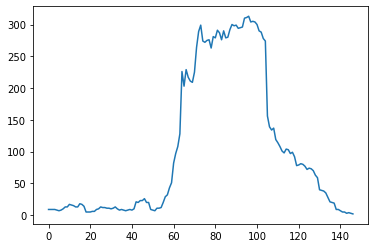

In [24]:
full_df[full_df['LGA'] == "MELBOURNE"].reset_index().Active.plot()